In [1]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
# import igraph as ig
from copy import deepcopy
from matplotlib import cm
%matplotlib inline
from collections import defaultdict

sns.set(style='white', palette='Set2', font_scale=1.2)

def assign_colors(vals, cmap='Set2'):
    ''' return a dictionary of { value: (R,G,B,a) } '''
    if type(cmap) == str:
        cmap = cm.get_cmap(cmap)
    try:
        vals = sorted(list(set(vals)))
    except:
        pass
    nvals = len(vals)
    
    colors = [cmap(i/nvals) for i in range(nvals)]
    
    return { val: colors[i] for i,val in enumerate(vals) }

In [2]:
### Utils
def name_to_int(adata, names):
    return np.where(adata.obs_names.isin(names))[0]

def get_shared_cellnames(adata1, adata2):
    return list(set(adata1.obs_names).intersection(set(adata2.obs_names)))

def get_shared_indices(adata1, adata2):
    shared_names = get_shared_cellnames(adata1, adata2)
    idx1 = name_to_int(adata1, shared_names)
    idx2 = name_to_int(adata2, shared_names)
    return idx1, idx2

### Subset neighbor graph & pca

def subset_neighbor_graph(full_neighbors, indices):
    
    subset_neighbors = deepcopy(full_neighbors)
    subset_neighbors['connectivities'] = subset_neighbors['connectivities'][np.ix_(indices, indices)]
    subset_neighbors['distances'] = subset_neighbors['distances'][np.ix_(indices, indices)]
    
    assert subset_neighbors['connectivities'].shape == (len(indices), len(indices)), (subset_neighbors['connectivities'].shape, len(indices))
    assert subset_neighbors['distances'].shape == (len(indices), len(indices)), (subset_neighbors['distances'].shape, len(indices))
    
    return subset_neighbors

def subset_pca(full_pca, indices):
    return full_pca[indices, :]

### Subset adata

def subset_adata(full_adata, selected_names, keep_preprocessing=False):
#     Populate subset adata object with either clean reruns of pca and neighbors or with subsets of the parent adata
    selected_indices = name_to_int(full_adata, selected_names)
    subset = deepcopy(full_adata)[selected_names, :]

    if keep_preprocessing:
        subset.uns['neighbors'] = subset_neighbor_graph(full_adata.uns['neighbors'], selected_indices)
        subset.obsm['X_pca'] = subset_pca(full_adata.obsm['X_pca'], selected_indices)
        
    else:
        sc.pp.pca(subset)
        sc.pp.neighbors(subset)
        
    return subset
        
### Run full set of downstream analyses
def run_analysis(adata, root):
    
    sc.tl.umap(adata)
    sc.tl.louvain(adata)
    sc.tl.diffmap(adata)
    
    adata.var['xroot'] = adata[root, :].X
    sc.tl.dpt(adata)

In [3]:
## Init the full dataset
rawdata = sc.read('./data/Marrow-counts.csv').transpose() 
cell_annotation = pd.read_csv('./data/annotations_FACS.csv', index_col=0) 
rawdata.obs['cell_type'] = cell_annotation.cell_ontology_class

full = sc.pp.recipe_seurat(rawdata, copy=True, log=False)
sc.pp.pca(full)
sc.pp.neighbors(full)

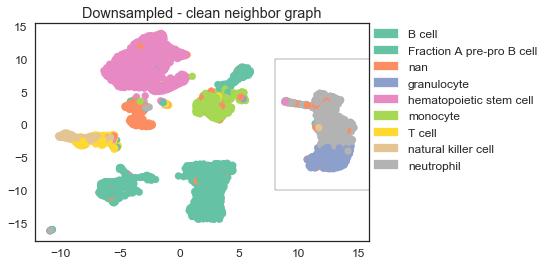

neutrophil                   590
granulocyte                  377
natural killer cell            3
hematopoietic stem cell        2
B cell                         2
Fraction A pre-pro B cell      1
Name: cell_type, dtype: int64


In [4]:
### Pull a subselection that is contiguous in umap space (should also be contiguous in neighbor graph space)
### Call it 'gran' because it contains mostly granulocytes + neutrophils

def plot_umap(adata, colorby = 'cell_type', title=None, show=True):
    fig, ax = plt.subplots()
    color_dict = assign_colors(pd.unique(adata.obs[colorby]))
    colors = [ color_dict[k] for k in adata.obs[colorby] ]
    plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=colors)
    
    legend_handles = []
    for val, color in color_dict.items():
        patch = patches.Patch(color=color, label=val)
        legend_handles.append(patch)
        
    plt.legend(loc=(1,.3),handles=legend_handles)

    if title:
        ax.set_title(title)
        
    if show:
        plt.show()
    return fig, ax

sc.tl.umap(full)

fig, ax = plot_umap(full, colorby='cell_type', title='Downsampled - clean neighbor graph', show=False)
patch = patches.Rectangle((8,-10),width=8,height=20, fill=False, ec='k')
ax.add_patch(patch)
plt.show()

full_umap_x = full.obsm['X_umap'][:,0]
full_umap_y = full.obsm['X_umap'][:,1]
gran_mask = (8 <= full_umap_x) & (full_umap_x <= 16) & (-10 <= full_umap_y) & (full_umap_y <= 10)
gran_names = full.obs_names[gran_mask]
gran_clean = subset_adata(full, gran_names, keep_preprocessing = False)
gran_subset = subset_adata(full, gran_names, keep_preprocessing = True)

print(pd.value_counts(gran_clean.obs['cell_type']))

In [5]:
### Make another subset that is noncontiguous in umap space (or neighbor graph space) 
### by subsampling evenly across all cell types in the dataset

def get_cluster_downsampled_names(adata, N, group_key = 'cell_type'):
    '''Cluster-informed downsampling of cells in an anndata object
       adata: anndata object
       N: total N to downsample to
       group_key: where to find cluster IDs in adata.obs[]
       returns list of names for selected observations
    '''
    assert 1 < N < len(adata.obs_names)
    assert group_key in adata.obs.columns.values, 'Oops. Choose another group key.'

    total_N = len(adata.obs_names)
    groups = adata.obs.groupby(group_key)
    all_selected = []

    for g, cells in groups.groups.items():
        group_size = len(cells)
        choose_k = int(N*(group_size/total_N))
        selected = random.sample(list(cells), k=choose_k)
        all_selected += selected
        
    return all_selected

subsampled_names = get_cluster_downsampled_names(full, N=1000, group_key='cell_type') ## full dataset, evenly downsampled 1:5
subsampled_clean = subset_adata(full, subsampled_names, keep_preprocessing=False)
subsampled_subset = subset_adata(full, subsampled_names, keep_preprocessing=True)

In [6]:
## choose a random root for dpt pseudotime that is present in all three datasets
random_shared_root = random.choice(get_shared_cellnames(subsampled_clean, gran_clean)) 
run_analysis(full, random_shared_root)
run_analysis(subsampled_subset, random_shared_root)
run_analysis(subsampled_clean, random_shared_root)
run_analysis(gran_subset, random_shared_root)
run_analysis(gran_clean, random_shared_root)

/usr/local/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:830: RuntimeWarning: divide by zero encountered in true_divide
  Q = scipy.sparse.spdiags(1.0/q, 0, W.shape[0], W.shape[0])
/usr/local/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:840: RuntimeWarning: divide by zero encountered in true_divide
  self.Z = scipy.sparse.spdiags(1.0/z, 0, K.shape[0], K.shape[0])


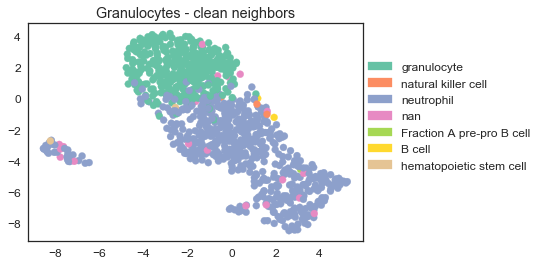

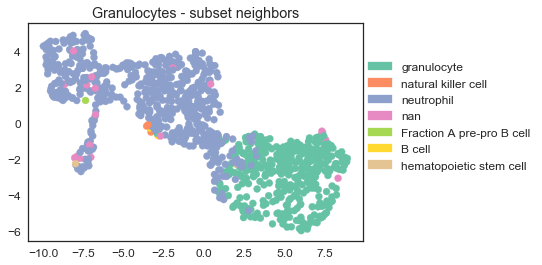

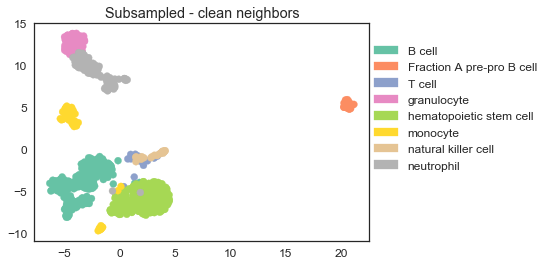

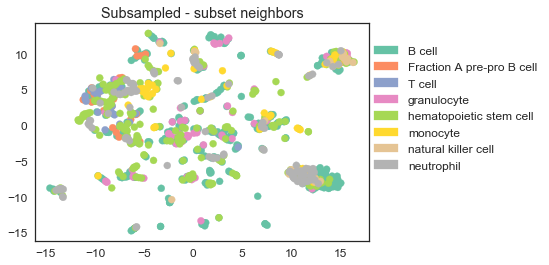

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x112092d30>)

In [47]:
## Compare effects on umap layout

plot_umap(gran_clean, title='Granulocytes - clean neighbors')
plot_umap(gran_subset, title='Granulocytes - subset neighbors')
plot_umap(subsampled_clean, title='Subsampled - clean neighbors')
plot_umap(subsampled_subset, title='Subsampled - subset neighbors')

Text(0.5,1,'Granulocytes: subset neighbor graph')

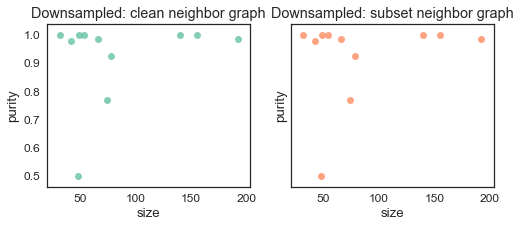

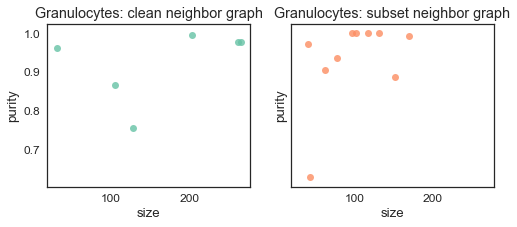

In [10]:
## Compare effects on clustering

def calc_cluster_purity(adata, cluster_key, compare_key):
    
    clusters = adata.obs[cluster_key].values
    compare = adata.obs[compare_key].values
    
    cluster_groups = defaultdict(list)
    for cl, cp in zip(clusters, compare):
        cluster_groups[cl].append(cp)

    cluster_size =   { cl: len(cp) 
                      for cl, cp in cluster_groups.items()}
    cluster_groups = { cl: pd.value_counts(cp) 
                      for cl, cp in cluster_groups.items() }
    
    cluster_purity = { cl: cp[0]/cp.sum() 
                      for cl, cp in cluster_groups.items()}
    
    return pd.DataFrame({'size': cluster_size, 'purity': cluster_purity})
    
small_clean_cluster_purity = calc_cluster_purity(subsampled_clean, 'louvain', 'cell_type')
small_subset_cluster_purity = calc_cluster_purity(subsampled_clean, 'louvain', 'cell_type')

fig, axes = plt.subplots(ncols=2,nrows=1, sharex=True, sharey=True, figsize=(8,3))
sns.regplot('size', 'purity', small_clean_cluster_purity, fit_reg=False, ax=axes[0])
axes[0].set_title('Downsampled: clean neighbor graph')

sns.regplot('size', 'purity', small_subset_cluster_purity, fit_reg=False, ax=axes[1])
axes[1].set_title('Downsampled: subset neighbor graph')


bcell_clean_cluster_purity = calc_cluster_purity(gran_clean, 'louvain', 'cell_type')
bcell_subset_cluster_purity = calc_cluster_purity(gran_subset, 'louvain', 'cell_type')

fig, axes = plt.subplots(ncols=2,nrows=1, sharex=True, sharey=True, figsize=(8,3))
sns.regplot('size', 'purity', bcell_clean_cluster_purity, fit_reg=False, ax=axes[0])
axes[0].set_title('Granulocytes: clean neighbor graph')

sns.regplot('size', 'purity', bcell_subset_cluster_purity, fit_reg=False, ax=axes[1])
axes[1].set_title('Granulocytes: subset neighbor graph')



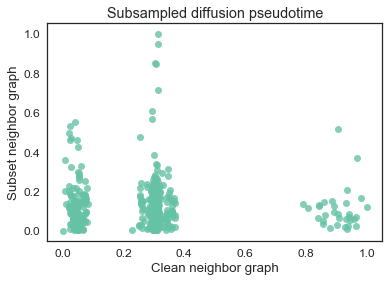

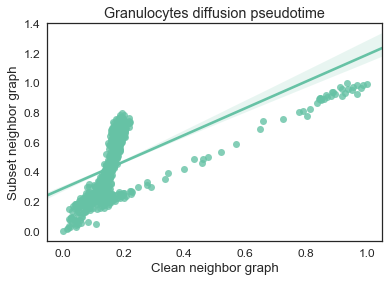

In [14]:
## Compare effects on dpt

def compare_pseudotime(adata1, adata2, title=None):
    
    shared_cells = get_shared_cellnames(adata1, adata2)
    random_start = random.choice(shared_cells)
    
    if 'dpt_pseudotime' not in adata1.obs:
        sc.tl.diffmap(adata1)
        adata1.var['xroot'] = adata1[random_start,:].X
        sc.tl.dpt(adata1)
        
    if 'dpt_pseudotime' not in adata2.obs:
        sc.tl.diffmap(adata2)
        adata2.var['xroot'] = adata2[random_start,:].X
        sc.tl.dpt(adata2)
     
    dpt1 = pd.Series(adata1.obs['dpt_pseudotime'], index=adata1.obs_names)
    dpt2 = pd.Series(adata2.obs['dpt_pseudotime'], index=adata2.obs_names)
        
    ax = sns.regplot(dpt1[shared_cells], dpt2[shared_cells])
    ax.set_xlabel('Clean neighbor graph')
    ax.set_ylabel('Subset neighbor graph')
    
    if title:
        ax.set_title(title)
        
    plt.show()
    
compare_pseudotime(subsampled_clean, subsampled_subset, 'Subsampled diffusion pseudotime')
compare_pseudotime(gran_clean, gran_subset, 'Granulocytes diffusion pseudotime')

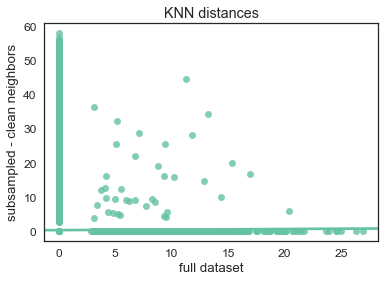

{'sensitivity': 0.05213032581453634, 'specificity': 0.97531328320802}


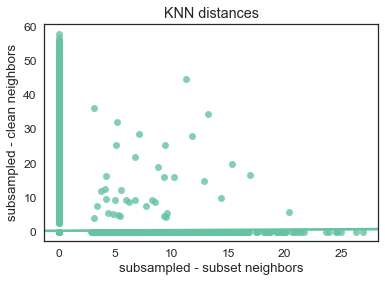

{'sensitivity': 0.05213032581453634, 'specificity': 0.97531328320802}


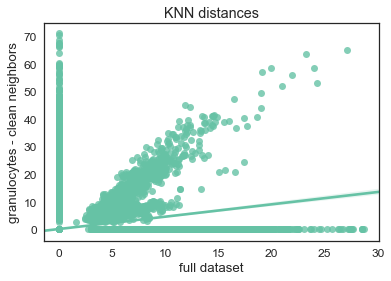

{'sensitivity': 0.38995125609298836, 'specificity': 0.9833935107585663}


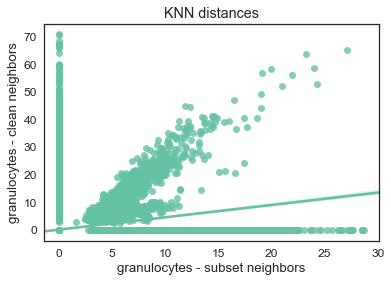

{'sensitivity': 0.38995125609298836, 'specificity': 0.9833935107585663}


{'sensitivity': 0.38995125609298836, 'specificity': 0.9833935107585663}

In [45]:
## Compare effects on connections / underlying graph structure

def connection_sensitivity_specificity(adata1, adata2, plot=True, xlabel=None, ylabel=None):
    ''' Assumes adata1 represents the "gold standard" and adata2 is the comparison '''
        
    # restrict neighbors to shared indices
    idx1, idx2 = get_shared_indices(adata1, adata2)
    shared_neighbors_adata1 = subset_neighbor_graph(adata1.uns['neighbors'], idx1)
    shared_neighbors_adata2 = subset_neighbor_graph(adata2.uns['neighbors'], idx2)
    
    # pull adjacency weights, restrict to upper triangle, and flatten for easy comparison
    adjacency1 = shared_neighbors_adata1['connectivities'].toarray()
    adjacency2 = shared_neighbors_adata2['connectivities'].toarray()
    adjacency1 = adjacency1[np.triu_indices_from(adjacency1)].flatten()
    adjacency2 = adjacency2[np.triu_indices_from(adjacency2)].flatten()
    
    if plot:
        # do the same for distances
        distances1 = shared_neighbors_adata1['distances'].toarray()
        distances2 = shared_neighbors_adata2['distances'].toarray()
        distances1 = distances1[np.triu_indices_from(distances1)].flatten()
        distances2 = distances2[np.triu_indices_from(distances2)].flatten()

        
        ax = sns.regplot(distances1, distances2)
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        ax.set_title('KNN distances')
        plt.show()
    
    # calculate sensitivity and specificity for binary connected/unconnected pairs
    tp = ((adjacency1 > 0) & (adjacency2 > 0)).sum().sum() ## true positive: both connected
    tn = ((adjacency1 == 0) & (adjacency2 == 0)).sum().sum() ## true negative: both unconnected
    fp = ((adjacency1 == 0) & (adjacency2 > 0)).sum().sum() ## false positive: 1 unconnected, 2 connected
    fn = ((adjacency1 > 0) & (adjacency2 == 0)).sum().sum() ## false negative: 1 connected, 2 unconnected
        
    stats = {'sensitivity': tp / (tp+fn), 'specificity': tn / (tn+fp)}
    print(stats)
    return stats

    
connection_sensitivity_specificity(full, subsampled_clean, xlabel='full dataset', ylabel='subsampled - clean neighbors')
connection_sensitivity_specificity(subsampled_subset,subsampled_clean, xlabel='subsampled - subset neighbors', ylabel='subsampled - clean neighbors')
connection_sensitivity_specificity(full, gran_clean, xlabel='full dataset', ylabel='granulocytes - clean neighbors')
connection_sensitivity_specificity(gran_subset,gran_clean, xlabel='granulocytes - subset neighbors', ylabel='granulocytes - clean neighbors')

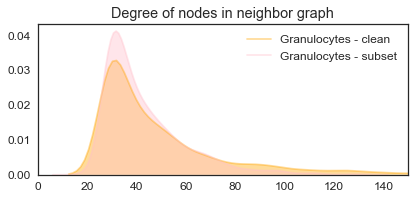

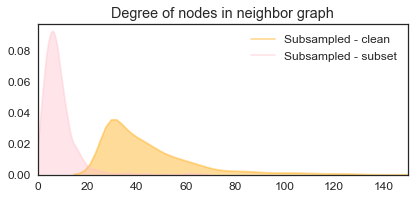

In [71]:
def get_igraph_from_adjacency(adjacency, directed=None):
    """Get igraph graph from adjacency matrix. (borrowed directly from scanpy)"""
    import igraph as ig
    sources, targets = adjacency.nonzero()
    weights = adjacency[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=directed)
    g.add_vertices(adjacency.shape[0])  # this adds adjacency.shap[0] vertices
    g.add_edges(list(zip(sources, targets)))
    try:
        g.es['weight'] = weights
    except:
        pass
    if g.vcount() != adjacency.shape[0]:
        logg.warn('The constructed graph has only {} nodes. '
                  'Your adjacency matrix contained redundant nodes.'
                  .format(g.vcount()))
    return g

def compare_knn_degree(adata1, adata2, label1=None, label2=None):
    
    ig1 = get_igraph_from_adjacency(adata1.uns['neighbors']['connectivities'])
    ig2 = get_igraph_from_adjacency(adata2.uns['neighbors']['connectivities'])
    
    deg1 = ig1.vs.degree()
    deg2 = ig2.vs.degree()
    
    fig, ax = plt.subplots(figsize=(6,3))
    sns.kdeplot(deg1, alpha=0.4, label=label1, shade=True, ax=ax, color='orange')
    sns.kdeplot(deg2, alpha=0.4, label=label2, shade=True, ax=ax, color='pink')
    
    ax.set_xlim(0, 150)
    ax.set_title('Degree of nodes in neighbor graph')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
sns.set(style='white', font_scale=1.2)
compare_knn_degree(gran_clean, gran_subset, 'Granulocytes - clean', 'Granulocytes - subset')
compare_knn_degree(subsampled_clean, subsampled_subset, 'Subsampled - clean', 'Subsampled - subset')

In [46]:
# def roc_curve(adata1, adata2, K=[5, 10, 15, 20, 25, 30], keep_preprocessing=True):
    
#     idx1, idx2 = get_shared_indices(adata1, adata2)
    
#     vals = []
    
#     for k in K:
        
#         adata1_copy = deepcopy(adata1)
#         adata2_copy = deepcopy(adata2)
        
#         sc.pp.neighbors(adata1_copy, n_neighbors=k, knn=True)
#         if keep_preprocessing:
#             adata2_copy.uns['neighbors'] = subset_neighbor_graph(adata1_copy, idx1)
#         else:
#             sc.pp.neighbors(adata2_copy, n_neighbors=k, knn=True)
            
        
#         sens_spec = connection_sensitivity_specificity(adata1_copy, adata2_copy, plot=False)
#         sens_spec.update({'k': k})
#         vals.append(sens_spec)
        
#     return pd.DataFrame(vals)


# gran_roc = roc_curve(gran_subset, gran_clean, keep_preprocessing=False)
# subset_roc = roc_curve(subsampled_subset, subsampled_clean, keep_preprocessing=False)